# Reading Petrel points

In [1]:
import re
import numpy as np
from io import StringIO

In [2]:
import geopandas as gp
from shapely.geometry import Point, LineString

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
points_file = "../data/Petrel_points_extract.txt"

Let's look at the start of the file:

In [5]:
with open(points_file) as f:
    c = f.read()
print(c[:256])

# Petrel Points with attributes
# Unit in X and Y direction: m
# Unit in depth: m
VERSION 1
BEGIN HEADER
X
Y
Z
END HEADER
374667.10 4541269.76 -5199.68 
374662.03 4541281.19 -5199.59 
374656.96 4541292.62 -5199.50 
374651.89 4541304.04 -5199.44 
374646.83 


We can make a function to parse the header into some variables, and read the bulk of the file – the data — into a NumPy array.

In [6]:
def gdf_from_points(points_file):
    """
    Read a Petrel points file and create a GeoPandas DataFrame.
    """
    with open(points_file) as f:
        comments, fields = [], []
        in_header = False

        while True:
            line = f.readline().strip()
            if line.startswith('#'):
                comments.append(line.strip('# '))
            elif line.startswith('VERSION'):
                version = line.split()[-1]
            elif line.startswith('BEGIN'):
                in_header = True
            elif line.startswith('END'):
                in_header = False
                break
            elif in_header:
                fields.append(line.strip())
            else:
                break

        d = f.read()
        s = StringIO(d)
        data = np.loadtxt(s)

        geoseries = gp.GeoSeries([Point(r[0], r[1]).buffer(5) for r in data])
        d = {'geometry': geoseries, 'twt': -data[:,2]}

        return gp.GeoDataFrame(d)

Read the subset of data:

In [7]:
seafloor = gdf_from_points(points_file)

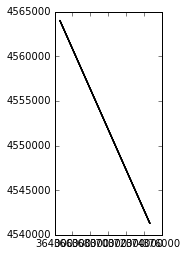

In [9]:
seafloor.plot()
plt.show()

## Petrel horizons

In [10]:
horizon_file = "../data/Petrel_IESX2D_horizon_extract.txt"

In [12]:
with open(horizon_file) as f:
    c = f.read()
    
print(c[:512])

PROFILE Fault to seafloor    TYPE 1  5 By Petrel 2014.2 (64-bit)                2d_ci7m_gf.ifdf  m  ms
SNAPPING PARAMETERS 5     2 2
  4.19846879E+05  4.66812161E+06  1 14  2742.85   5460.00  16382.00 4262               2 276-109::normTOv                          
  4.19840089E+05  4.66813210E+06  1 14  2756.25   5461.00  16383.00 4263               2 276-109::normTOv                          
  4.19833299E+05  4.66814259E+06  1 14  2769.65   5461.00  16384.00 4264               2 276-109::normTOv          


Not totally sure what all these fields are. There seems to be two rows of header info for each horizon. This is followed by space-delimited data fields with columns as follows:

1. X-coordinate, float
1. Y-coordinate, float
1. Segment number, int
1. Symbol code, int
1. Two-way time (ms), float
1. Shot-point number, float
1. CDP number, float
1. Trace number, int
1. Line type (2=2D, I=inline, X=crossline), int
1. 2D line name or 3D survey name, str

I have asked about this [on Stack Exchange](http://earthscience.stackexchange.com/questions/4897/what-are-the-fields-in-petrels-iesx-seismic-horizon-file) and on LinkedIn. 

In [13]:
import re
s = "PROFILE Fault to seafloor    TYPE 1  5 By Petrel 2014.2 (64-bit)                2d_ci7m_gf.ifdf  m  ms"
re.search(r'PROFILE (.+?) +TYPE', s).group(1)

'Fault to seafloor'

I think we can use the first integer as a sort of flag to determine the start of a new 'segment'. 

I want to make a shapefile with line segments, I think. Not totally sure about that...

In [19]:
import operator, re

def gdf_from_iesx(filename, threed=False):
    """
    Read a Petrel IESX file and create a GeoPandas DataFrame.
    """
    with open(filename) as f:

        points, linestrings, names = [], [], []
        mins, maxs = [], []
        min_sfls, max_sfls = [], []
        minx, miny = [], []
        last_cdp = 0
        skip = False
        
        while True:
            line = f.readline().strip()        
            if not line:
                # End of file
                break
            elif line.startswith('EOD'):
                # End of horizon
                last_cdp = 0 # Force capture
            elif line.startswith('SNAPPING'):
                continue
            elif line.startswith('PROFILE'):
                name = re.search(r'PROFILE (.+?) +TYPE', line).group(1)
                
                # Some 'label' horizons slipped though, skip 'em.
                if name.startswith('---'):
                    skip = True
                else:
                    skip = False
                    print()
                    print(name, end="")
            else:
                if skip == True:
                    continue
                
                line = line.split()
                x, y = float(line[0]), float(line[1])
                twtt = float(line[4])

                if threed:
                    this_cdp = int(line[5]) + int(line[9])
                else:
                    this_cdp = int(line[7])

                if abs(this_cdp - last_cdp) < 2:
                    # Then it's a regular line, so keep adding
                    points.append(Point(x, y, twtt))
                    last_cdp = this_cdp
                else:
                    if len(points) < 2:
                        last_cdp = this_cdp
                        continue
                        
                    print('.', end="")

                    # Capture what we have
                    linestrings.append(LineString(points))
                    names.append(name)
                    zs = [p.z for p in points]
                    
                    # We want the value and index of the min and max in the list of z values
                    min_idx, min_val = min(enumerate(zs), key=operator.itemgetter(1))
                    max_idx, max_val = max(enumerate(zs), key=operator.itemgetter(1))
                    
                    # Record the values and shallowest point in our master lists
                    mins.append(min_val)
                    maxs.append(max_val)
                    
                    p = points[min_idx]
                    minx.append(p.x)
                    miny.append(p.y)
                    
                    # Make GeoDataFrames from the points yielding the min and max
                    min_gdf = gp.GeoDataFrame({'geometry':gp.GeoSeries(p)})
                    max_gdf = gp.GeoDataFrame({'geometry':gp.GeoSeries(points[max_idx])})
                    
                    # Reset segment and carry on
                    last_cdp = this_cdp
                    points = [Point(x, y, twtt)]
                    
    return gp.GeoDataFrame({'geometry': linestrings,
                            'name': names,
                            'min': mins,
                            'max': maxs,
                            'minx': minx,
                            'miny': miny
                           })

Test on a small bit:

In [20]:
hrz = gdf_from_iesx(horizon_file)


Fault to seafloor...................

In [21]:
hrz.head()

,geometry,max,min,minx,miny,name
0,"LINESTRING Z (419840.089 4668132.1 2756.25, 41...",3707.73,2733.93,419819.720,4668163.57,Fault to seafloor
1,"LINESTRING Z (412513.896 4679451.12 2570.42, 4...",4082.56,2570.42,412513.896,4679451.12,Fault to seafloor
2,"LINESTRING Z (417373.758 4666148.69 3549.57, 4...",3549.57,2732.92,416622.455,4667313.88,Fault to seafloor
3,"LINESTRING Z (416473.548 4667544.82 2779.94, 4...",3671.84,2779.94,416473.548,4667544.82,Fault to seafloor
4,"LINESTRING Z (433915.846 4651537.09 3346.44, 4...",4457.18,3346.44,433915.846,4651537.09,Fault to seafloor


Add a CRS...

In [23]:
from fiona.crs import from_epsg
hrz.crs = from_epsg(26720)

Try a quick plot...

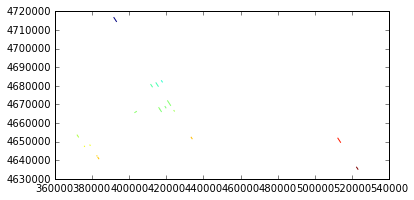

In [26]:
fig = plt.figure(figsize=(18,10))
ax = hrz.plot(column='min')
plt.show()

Write a file if you like.

In [27]:
# hrz.to_file('../data/horizons_2d_UTM20N_NAD27.shp')

## Petrel well headers

A format for importing wells into Petrel (or exporting from Petrel?). (Leaving this for later.)

    # Petrel well head
    VERSION 1							
    BEGIN HEADER							
    Well_ID							
    Well_sequence_number							
    Well_name							
    Surface X [m] NAD 83							
    Surface Y [m] NAD 83							
    KB elevation above sea level							
    TD [m]							
    Operator							
    END HEADER							
     ' P-139 ' 	 ' 139 ' 	 ' ECE-13-P2_ST ' 	529557	5045390	44.68	1,259.00	 ' East Coast Energy ' 
     ' P-138 ' 	 ' 138 ' 	 ' ECE-13-P1 ' 	529996	5045966	39.89	700	 ' East Coast Energy ' 
     ' P-137 ' 	 ' 137 ' 	 ' Forent South Branch No.1 K-70-D/11-E-03 ' 	496239	5003586	55.9	784	 ' Forent Energy Ltd ' 
     ' P-136 ' 	 ' 136 ' 	 ' Forent Alton No. 1 E-49-C 11-E-03  ' 	479105	5003441	40.23	1001	 ' Forent Energy Ltd. ' 
     ' P-135 ' 	 ' 135 ' 	 ' E-38-A/11-E-5 ' 	420980	5056480	123	946	 ' Eastrock Resources ' 
     ' P-134 ' 	 ' 134 ' 	 ' ECE-11-01 ' 	529976	5045865	43	678	 ' East Coast Energy ' 
     ' P-133 ' 	 ' 133 ' 	 ' E-38-A/11-E-5 ' 	443001	5015963	51	1726	 ' Elmworth Energy Corporation ' 